In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, Descent, params, throttle, @epochs

using Base.Iterators: repeated

using PyPlot, DataFrames, ExcelFiles, MLDataUtils, HDF5, ProgressMeter

loaded


# DATA IMPORT

In [2]:
X_columns = h5read("./data/DataSet.hdf5", "X_columns")

X_tv = h5read("./data/DataSet.hdf5", "X_tv")
X_tv_sc = h5read("./data/DataSet.hdf5", "X_tv_sc")
y_tv = h5read("./data/DataSet.hdf5", "y_tv")

X_test = h5read("./data/DataSet.hdf5", "X_test")
X_test_sc = h5read("./data/DataSet.hdf5", "X_test_sc")
y_test = h5read("./data/DataSet.hdf5", "y_test")

X_scaler_mean = h5read("./data/DataSet.hdf5", "X_scaler_mean")
X_scaler_var = h5read("./data/DataSet.hdf5", "X_scaler_var")
println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_tv))

# Put unscaled values for ap, b, T, Be and Sc in X_tv_sc and X_test_sc
X_tv_sc[5:end,:] = X_tv[5:end,:]
X_test_sc[5:end,:] = X_test[5:end,:]

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "ap", "b", "T", "Be", "Sc", "tg"]

Shape of X train and valid is
(10, 689)


6×128 Array{Float64,2}:
    13.2745      13.2745      13.2745   …   -0.6136      -0.6136   
     0.0          0.0          0.0           0.007082     0.007082 
   810.0        790.0        770.0         905.1        896.6      
 76534.6      76534.6      76534.6           1.57634e5    1.57634e5
     7.54316      7.54316      7.54316      12.9857      12.9857   
   714.0        714.0        714.0      …  894.9        894.9      

# Model

In [3]:
# The model

#
# Cps
#

at_gfu(x) = 3.0.*x[1,:] .+ 5.0.*x[2,:] + 3.0.*x[3,:] + 3.0.*x[4,:]# + 2*MgO + 2*MgO
aCpl(x) = 81.37.*x[1,:] .+ 27.21.*x[2,:] .+ 100.6.*x[3,:]  .+ 50.13.*x[4,:] .+ x[1,:].*(x[4,:].*x[4,:]).*151.7

ap(x) = reshape(aCpl(x) - 3.0.*8.314.*at_gfu(x),1,size(x,2))
b(x) = reshape(0.0943.*x[2,:] + 0.01578.*x[4,:],1,size(x,2)) #bCpl

#
# With two subnetworks for Be and Sc
#
m1 = Chain(
  Dense(4, 10, relu),
  Dense(10, 1)) |> gpu

m2 = Chain(
  Dense(4, 8, relu),
  Dense(8, 1)) |> gpu

Be(x) = exp.(m1(x[1:4,:]))
ScTg(x) = exp.(m2(x[1:4,:]))

# Other stuffs

Ae = param([-2.11])

tg(x) = Be(x)./((12.0.-Ae).*ScTg(x))

dCp(x,T, ap, b) = ap.*(log.(T).-log.(tg(x))) .+ b.*(T.-tg(x))

model(x,T, ap, b) = Ae .+ Be(x) ./ (T.* (ScTg(x) .+ dCp(x,T, ap, b)))

mse(yp, y) = sqrt(sum((yp .- y).^2)./size(y, 2))

predict(x,T, ap, b) = model(x,T, ap, b)

# loss functions
loss(x, T, ap, b, y) = mse(model(x, T, ap, b), y)
loss_be(x,be) = mse(Be(x),be)
loss_sc(x,sc) = mse(ScTg(x),sc)
loss_tg(x,target) = mse(tg(x),target)

loss_tg (generic function with 1 method)

# Training

In [4]:
function prepare_datas(X_,y_)
    
    y = reshape(y_[:],1,length(y_))
    
    x = X_[1:4,:]
    ap = reshape(X_[5,:],1,size(X_,2))
    b = reshape(X_[6,:],1,size(X_,2))
    T = reshape(X_[7,:],1,size(X_,2))
    be = reshape(X_[8,:],1,size(X_,2))
    sc = reshape(X_[9,:],1,size(X_,2))
    tg = reshape(X_[10,:],1,size(X_,2))
    return x, y, T, ap, b, sc, be, tg
end

prepare_datas (generic function with 1 method)

In [5]:
print(X_columns)

["sio2", "al2o3", "na2o", "k2o", "ap", "b", "T", "Be", "Sc", "tg"]

In [6]:
X_tv_sc, y_tv = shuffleobs((X_tv_sc,y_tv))
folds = kfolds((X_tv_sc,y_tv), k = 5);

In [7]:
record_loss_be_train = Float64[]
record_loss_be_valid = Float64[]

#opt = Descent(0.001)
opt = ADAM(0.001)
fold_select = 1
nb_epochs = 1500

p = ProgressMeter.Progress(nb_epochs, 1)   # minimum update interval: 1 second
for epoch_idx in 1:nb_epochs
    
    train,valid = folds[fold_select]
    
    x_train, y_train, T_train, ap_train, b_train, sc_train, be_train, tg_train = prepare_datas(train[1],train[2])
    x_valid, y_valid, T_valid, ap_valid, b_valid, sc_valid, be_valid, tg_valid = prepare_datas(valid[1],valid[2])
    
    evalcb = () -> (push!(record_loss_be_train,loss_be(x_train, be_train).data),push!(record_loss_be_valid,loss_be(x_valid, be_valid).data)) #@show(loss_be(x_train, be_train),loss_be(x_valid, be_valid))

    Flux.train!(loss_be, params(m1), [(x_train, be_train)], opt, cb = throttle(evalcb, 1))
    
    ProgressMeter.update!(p, epoch_idx)
    #fold_select += 1
    #if fold_select >= 6
    #    fold_select = 1
    #end
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


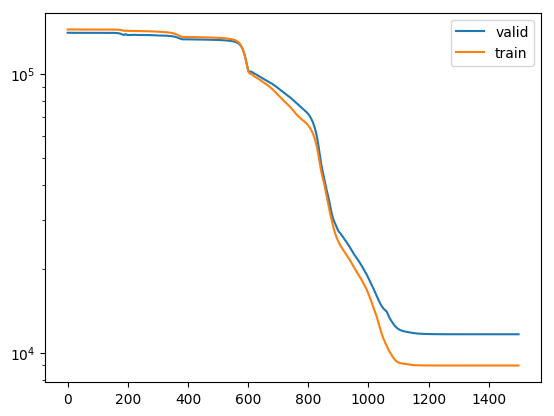

PyObject <matplotlib.legend.Legend object at 0x7f7b8c0e4e50>

In [8]:
plot(record_loss_be_valid,label="valid")
plot(record_loss_be_train,label="train")
yscale("log")
legend()

In [9]:
record_loss_sc_train = Float64[]
record_loss_sc_valid = Float64[]

#opt = Descent(0.001)
opt = ADAM(0.001)
fold_select = 1
nb_epochs = 1500

p = ProgressMeter.Progress(nb_epochs, 1)   # minimum update interval: 1 second
for epoch_idx in 1:nb_epochs
    
    train,valid = folds[fold_select]
    
    x_train, y_train, T_train, ap_train, b_train, sc_train, be_train, tg_train = prepare_datas(train[1],train[2])
    x_valid, y_valid, T_valid, ap_valid, b_valid, sc_valid, be_valid, tg_valid = prepare_datas(valid[1],valid[2])
    
    evalcb = () -> (push!(record_loss_sc_train,loss_sc(x_train, sc_train).data),push!(record_loss_sc_valid,loss_sc(x_valid, sc_valid).data)) #@show(loss_be(x_train, be_train),loss_be(x_valid, be_valid))

    Flux.train!(loss_sc, params(m2), [(x_train, sc_train)], opt, cb = throttle(evalcb, 1))
    
    ProgressMeter.update!(p, epoch_idx)
    #fold_select += 1
    #if fold_select >= 6
    #    fold_select = 1
    #end
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


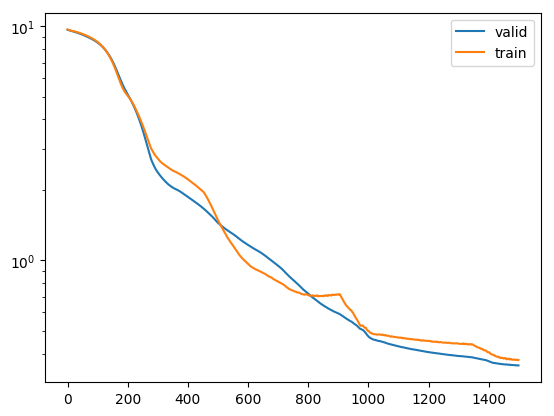

PyObject <matplotlib.legend.Legend object at 0x7f7b3cd403d0>

In [10]:
plot(record_loss_sc_train,label="valid")
plot(record_loss_sc_valid,label="train")
yscale("log")
legend()

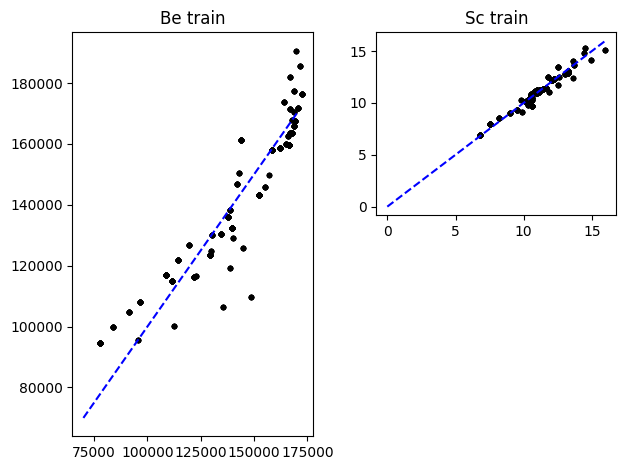

In [11]:
subplot(1,2,1)
title("Be train")
plot(X_tv_sc[8,:],Be(X_tv_sc[1:4,:]).data[:],"k.")
plot([70000.,170000.],[70000.,170000.],"b--")
subplot(2,2,2)
title("Sc train")
plot(X_tv_sc[9,:],ScTg(X_tv_sc[1:4,:]).data[:],"k.")
plot([0.,16.],[0.,16.],"b--")


tight_layout()

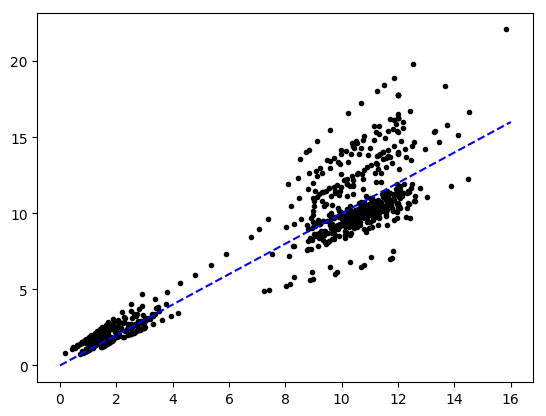

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7b3cc17890>

In [12]:
x_tv_, y_tv_, T_tv_, ap_tv_, b_tv_, sc_tv_, be_tv_, tg_tv_ = prepare_datas(X_tv_sc,y_tv)

plot(y_tv[:],
    model(x_tv_,T_tv_,ap_tv_, b_tv_).data[:],
    "k.")
plot([0.,16.],[0.,16.],"b--")

#println(loss(x_train,T_train, ap_train, b_train, y_train))

In [13]:
record_loss_n_train = Float64[]
record_loss_n_valid = Float64[]

opt = ADAM(0.001)
fold_select = 1
nb_epochs = 2000

p = ProgressMeter.Progress(nb_epochs, 1)   # minimum update interval: 1 second
for epoch_idx in 1:nb_epochs
    
    train,valid = folds[fold_select]
    
    x_train, y_train, T_train, ap_train, b_train, sc_train, be_train, tg_train = prepare_datas(train[1],train[2])
    x_valid, y_valid, T_valid, ap_valid, b_valid, sc_valid, be_valid, tg_valid = prepare_datas(valid[1],valid[2])
    
    evalcb = () -> (push!(record_loss_n_train,loss(x_train, T_train ,ap_train, b_train, y_train).data),
    push!(record_loss_n_valid,loss(x_valid, T_valid ,ap_valid, b_valid, y_valid).data)) #@show(loss_be(x_train, be_train),loss_be(x_valid, be_valid))

    dataset = [(x_train, T_train, ap_train, b_train, y_train)]
    Flux.train!(loss, params(Ae,m1,m2), dataset, opt, cb = throttle(evalcb, 1))
    
    ProgressMeter.update!(p, epoch_idx)
    #fold_select += 1
    #if fold_select >= 6
    #    fold_select = 1
    #end
    
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


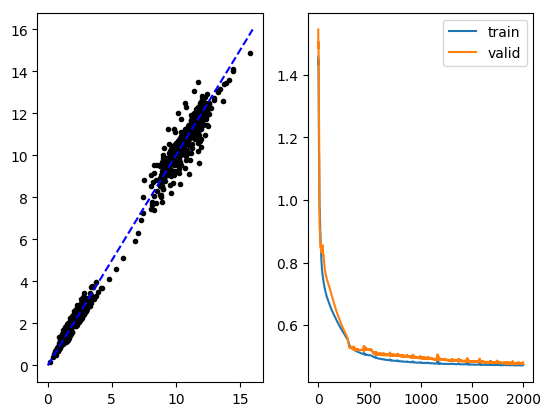

PyObject <matplotlib.legend.Legend object at 0x7f7b3cb596d0>

In [14]:
subplot(1,2,1)
plot(y_tv_[:],model(x_tv_,T_tv_,ap_tv_,b_tv_).data[:],"k.")
plot([0.,16.],[0.,16.],"b--")

subplot(1,2,2)
plot(record_loss_n_train,label="train")
plot(record_loss_n_valid,label="valid")
legend()

In [25]:
print(minimum(record_loss_n_train))

0.47129829510929055

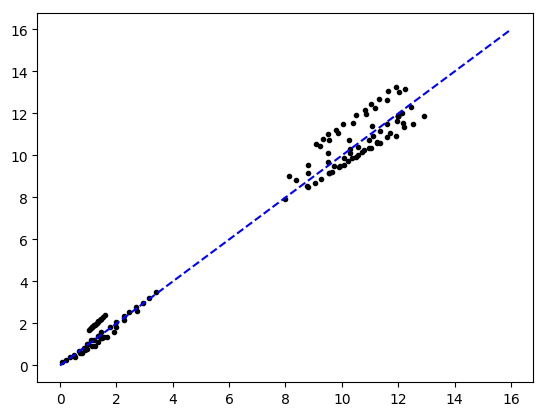

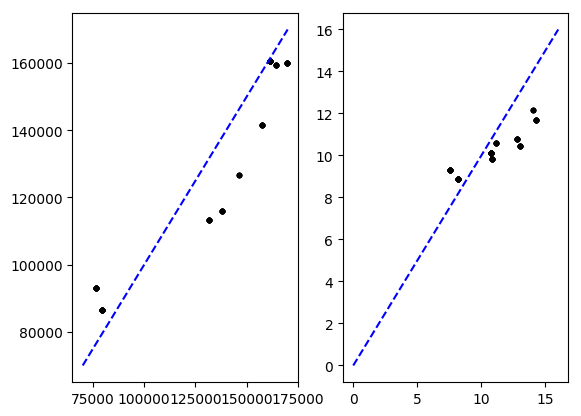

0.6652368608386181 (tracked)


In [15]:
x_test, y_test, T_test, ap_test, b_test, sc_test, be_test, tg_test = prepare_datas(X_test_sc,y_test)

#y_nn_v = model(x_v,T_v,ap_v,b_v)
plot(vec(y_test),model(x_test,T_test,ap_test,b_test).data[:],"k.")
plot([0.,16.],[0.,16.],"b--")

figure()
subplot(1,2,1)
plot(be_test[:],Be(x_test).data[:],"k.")
plot([70000.,170000.],[70000.,170000.],"b--")
subplot(1,2,2)
plot(sc_test[:],ScTg(x_test).data[:],"k.")
plot([0.,16.],[0.,16.],"b--")

println(loss(x_test,T_test,ap_test,b_test,y_test))

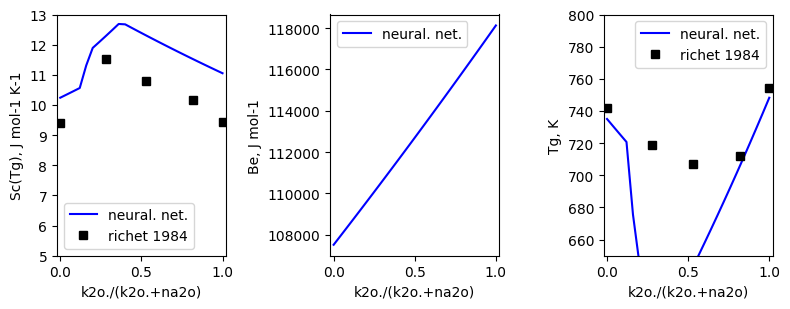

In [16]:
k2o = collect(0:0.01:0.25)
na2o = 0.25 .- k2o
sio2 = ones(size(k2o,1)).*0.75
al2o3 = zeros(size(k2o))

x_visu = [sio2';al2o3'; na2o'; k2o']

x_visu_sc = (x_visu .- X_scaler_mean[1:4,:])./sqrt.(X_scaler_var[1:4,:])

ap_x_visu = ap(x_visu)
b_x_visu = b(x_visu)

figure(figsize=(8,3.2))

subplot(1,3,1)
plot(k2o./(k2o.+na2o),ScTg(x_visu_sc).data'[:],"b-",label="neural. net.")
plot([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,"ks",label="richet 1984")
xlabel("k2o./(k2o.+na2o)")
ylabel("Sc(Tg), J mol-1 K-1")

ylim(5,13)
xlim(-0.02,1.02)
legend()

subplot(1,3,2)
plot(k2o./(k2o.+na2o),Be(x_visu_sc).data'[:],"b-",label="neural. net.")
xlabel("k2o./(k2o.+na2o)")
ylabel("Be, J mol-1")
legend()
xlim(-0.02,1.02)

subplot(1,3,3)
plot(k2o./(k2o.+na2o),tg(x_visu_sc).data'[:],"b-",label="neural. net.")
plot([0,0.28,0.53,0.82,1.0],[742.,719.,707.,712.,754.],"ks",label="richet 1984")

xlabel("k2o./(k2o.+na2o)")
ylabel("Tg, K")
legend()

ylim(650,800)
xlim(-0.02,1.02)


tight_layout()
savefig("./figures/Flux_KN_S3.pdf")

In [34]:
x_visu = X_scaler[:transform]([sio2 al2o3 na2o k2o])

subplot(1,3,1)
plot(k2o./(k2o.+na2o),ScTg(x_visu').data'[:],"o")
subplot(1,3,2)
plot(k2o./(k2o.+na2o),Be(x_visu').data'[:],"o")
subplot(1,3,3)
plot(k2o./(k2o.+na2o),tg(x_visu').data'[:],"o")

4×26 Array{Float64,2}:
 0.75  0.75  0.75  0.75  0.75  0.75  …  0.75  0.75  0.75  0.75  0.75  0.75
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 1.0   0.99  0.98  0.97  0.96  0.95     0.8   0.79  0.78  0.77  0.76  0.75
 0.0   0.01  0.02  0.03  0.04  0.05     0.2   0.21  0.22  0.23  0.24  0.25

In [299]:
predictions_train = predict(x)

Tracked 620×620 Array{Float64,2}:
 -4.49918  -4.49918  -4.49918  -4.49918  …  -4.4996   -4.4996   -4.4996 
 -4.49916  -4.49916  -4.49916  -4.49916     -4.49959  -4.49959  -4.49959
 -4.49912  -4.49912  -4.49912  -4.49912     -4.49957  -4.49957  -4.49957
 -4.49909  -4.49909  -4.49909  -4.49909     -4.49955  -4.49955  -4.49955
 -4.49904  -4.49904  -4.49904  -4.49904     -4.49953  -4.49953  -4.49953
 -4.49901  -4.49901  -4.49901  -4.49901  …  -4.49951  -4.49951  -4.49951
 -4.49896  -4.49896  -4.49896  -4.49896     -4.49949  -4.49949  -4.49949
 -4.49892  -4.49892  -4.49892  -4.49892     -4.49947  -4.49947  -4.49947
 -4.49885  -4.49885  -4.49885  -4.49885     -4.49943  -4.49943  -4.49943
 -4.49882  -4.49882  -4.49882  -4.49882     -4.49942  -4.49942  -4.49942
 -4.49871  -4.49871  -4.49871  -4.49871  …  -4.49936  -4.49936  -4.49936
 -4.49866  -4.49866  -4.49866  -4.49866     -4.49934  -4.49934  -4.49934
 -4.49861  -4.49861  -4.49861  -4.49861     -4.49931  -4.49931  -4.49931
  ⋮              

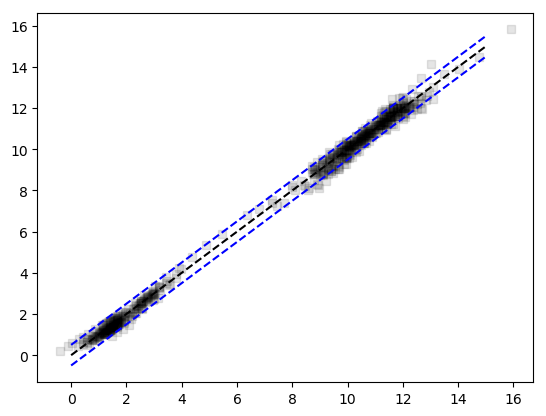

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f041fbb1cc0>

In [197]:
plot(predictions_train.data[:],y.parent[:],"ks",alpha=0.1)
plot([0,15],[0,15],"k--")
plot([0,15.0],[0,15.].-0.5,"b--")
plot([0,15.],[0,15.].+0.5,"b--")

In [195]:
plot([0,12]-0.5,[0,12]-0.5,"k--")

MethodError: MethodError: no method matching -(::Array{Int64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:397
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:97
  ...

In [188]:
predictions_train.data[:]

620-element Array{Float64,1}:
  2.3032444067117757
  2.623692405633248 
  3.027915455938361 
  3.4222450165673743
  3.8926449255113944
  4.370103390672524 
  4.8876503648035   
  5.469334558026265 
  6.356743420865268 
  6.78613859050153  
  8.327278676684431 
  9.051372238986819 
  9.944407111041677 
  ⋮                 
  1.4055438658956634
  1.4422492073169009
  1.479413679478652 
  1.5170459511904548
  1.5551549108774632
  1.5937496735794525
  1.6328395882192055
  1.6724342451524592
  9.332781439644776 
 10.09932163190039  
 10.621319672155154 
 11.212695098263817 

In [191]:
m1(x)

Tracked 1×620 Array{Float32,2}:
 15123.9  15123.9  15123.9  15123.9  …  8035.39  8035.39  8035.39  8035.39